In [1]:
import glob

from fastai.text import *
# from fastai.callbacks import SaveModelCallback
import sentencepiece as spm #https://github.com/google/sentencepiece

from prod.sp_tok import *

#torch.backends.cudnn.enabled=False #for quant.313v machine.  Not sure why...

In [2]:
PATH = Path('./data/rnn')
sp_model = './all_tweets_es_0609'

defaults.text_spec_tok.append(NL) #add a New Line special char
sp_vocab = Vocab( get_itos(sp_model) )
mycust_tok = CustomTokenizer(SPTokenizer,sp_model,pre_rules=default_rules)

In [3]:
test_df = pd.read_csv('./data/haha_2019_test.csv')
test_df['is_humor'] = 0
test_df['is_humor'].iloc[0] = 1 #create two classes in data.
## apply the rules
raw_text = test_df.loc[:,'text']

print("Default Rules:\n",[x.__name__ for x in default_rules],"\n\n")
for rule in default_rules:
    raw_text = raw_text.apply(lambda x: rule(str(x)))    
test_df['new_text'] =  raw_text #tokenizer adds xxbos

data_tst = TextClasDataBunch.from_df(PATH, test_df, test_df,
                               tokenizer=mycust_tok, vocab=sp_vocab,
                               text_cols='new_text', label_cols='is_humor')

In [4]:
model_wt_fnames = [x.split('/')[-1] for x in glob.glob( str(PATH/'models')+'/haha_clas_0609_fld*.pth')]
len(model_wt_fnames), model_wt_fnames[:5]

(104,
 ['haha_clas_0609_fld0_612713.pth',
  'haha_clas_0609_fld2_871553.pth',
  'haha_clas_0609_fld3_329890.pth',
  'haha_clas_0609_fld1_128040.pth',
  'haha_clas_0609_fld2_891870.pth'])

In [5]:
!grep Clas ./prod/out_fwd_tmp101.txt > ./by_seed_fwd_perf

In [6]:
## be more picky about the models.  Take the top quarter in validation. Does better val -> better test?
valid_perf = pd.read_csv('by_seed_fwd_perf', names = ['id','acc','F1'])
valid_perf['rnd_seed'] = valid_perf.id.str.split(':',expand=True).iloc[:,-1].str.strip()
valid_perf['nfold'] = valid_perf.id.str.split(' ',expand=True).iloc[:,2]
valid_perf.head()

,id,acc,F1,rnd_seed,nfold
0,Clas Fold: 0 RndSeed: 84154,0.863333,0.820109,84154,0
1,Clas Fold: 1 RndSeed: 84154,0.870625,0.826782,84154,1
2,Clas Fold: 2 RndSeed: 84154,0.865833,0.826363,84154,2
3,Clas Fold: 3 RndSeed: 84154,0.861667,0.816809,84154,3
4,Clas Fold: 4 RndSeed: 84154,0.863750,0.824062,84154,4


Text(0.5, 1.0, 'Freq of F1 over all Random Seeds (20) \n Vert line = MaxValue')

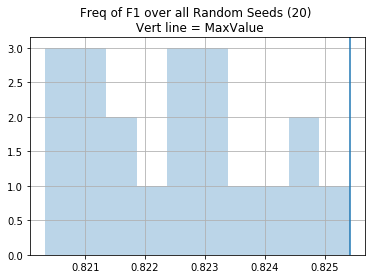

In [10]:
#valid_perf.F1.hist(alpha=0.3)
#plt.axvline(x=valid_perf.F1.quantile(0.75))
valid_perf.groupby('rnd_seed')['F1'].mean().hist(alpha=0.3)
plt.axvline(x=valid_perf.groupby('rnd_seed')['F1'].mean().max())
#valid_perf[valid_perf.F1 >= valid_perf.F1.quantile(0.75)].F1.hist(alpha=0.3)
plt.title('Freq of F1 over all Random Seeds (20) \n Vert line = MaxValue')

In [11]:
valid_perf.groupby('rnd_seed')['F1'].mean().describe()

count    20.000000
mean      0.822409
std       0.001502
min       0.820336
25%       0.820995
50%       0.822551
75%       0.823194
max       0.825419
Name: F1, dtype: float64

In [8]:
seed_grouped_F1 = valid_perf.groupby('rnd_seed')['F1'].mean()
# selected_seeds = seed_grouped_F1[seed_grouped_F1>=seed_grouped_F1.quantile(0.75)].index.values.tolist()

## best of all sampled seeds
selected_seeds = seed_grouped_F1[seed_grouped_F1>=seed_grouped_F1.max()].index.values.tolist()
seed_fold_pair = valid_perf[valid_perf.rnd_seed.isin(selected_seeds)].loc[:,['rnd_seed','nfold']].values
model_wt_fnames = []
for (seed,fold) in seed_fold_pair:
    model_wt_fnames.append(f'haha_clas_0609_fld{fold}_{seed}.pth')
model_wt_fnames

['haha_clas_0609_fld0_432286.pth',
 'haha_clas_0609_fld1_432286.pth',
 'haha_clas_0609_fld2_432286.pth',
 'haha_clas_0609_fld3_432286.pth',
 'haha_clas_0609_fld4_432286.pth']

In [9]:
ensemble_preds = []
for wt_fname in model_wt_fnames:
    config = awd_lstm_clas_config.copy()
    config['qrnn'] = True
    config['n_hid'] = 2304
    
    learn = text_classifier_learner(data_tst, AWD_LSTM, drop_mult=0.7,pretrained=False,
                               config=config)
    learn = learn.load(wt_fname.split('.')[0]) #load weights
    preds_t,y_t,losses_t = learn.get_preds(DatasetType.Valid,with_loss=True, ordered=True)
    ensemble_preds.append(to_np(preds_t))

In [10]:
np.array(ensemble_preds).shape

(5, 6000, 2)

In [11]:
np.array(ensemble_preds)[:5,...]

array([[[0.351104, 0.648896],
        [0.914596, 0.085404],
        [0.086162, 0.913838],
        [0.955686, 0.044314],
        ...,
        [0.717087, 0.282913],
        [0.864408, 0.135592],
        [0.335245, 0.664755],
        [0.247511, 0.752489]],

       [[0.343463, 0.656537],
        [0.925631, 0.074369],
        [0.017282, 0.982718],
        [0.986668, 0.013332],
        ...,
        [0.938606, 0.061394],
        [0.878058, 0.121942],
        [0.221435, 0.778565],
        [0.149304, 0.850696]],

       [[0.280253, 0.719747],
        [0.761115, 0.238885],
        [0.075569, 0.924431],
        [0.907151, 0.092849],
        ...,
        [0.557101, 0.442899],
        [0.957633, 0.042367],
        [0.174804, 0.825196],
        [0.148236, 0.851764]],

       [[0.270884, 0.729116],
        [0.818022, 0.181978],
        [0.085421, 0.914579],
        [0.975332, 0.024668],
        ...,
        [0.66776 , 0.33224 ],
        [0.905546, 0.094454],
        [0.360732, 0.639268],
        [0.2

In [12]:
ens_mean = np.array(ensemble_preds).mean(axis=0)
ens_mean

array([[0.308204, 0.691796],
       [0.867971, 0.132029],
       [0.062315, 0.937685],
       [0.960533, 0.039467],
       ...,
       [0.767459, 0.232541],
       [0.912002, 0.087998],
       [0.263458, 0.736542],
       [0.195676, 0.804324]], dtype=float32)

In [13]:
out_df = test_df['id'].to_frame().copy()
out_df['is_humor'] = ens_mean.argmax(axis=1)
out_df['funniness_average'] = 3.

In [14]:
out_df.head()

,id,is_humor,funniness_average
0,tweet1,1,3.0
1,tweet2,0,3.0
2,tweet3,1,3.0
3,tweet4,0,3.0
4,tweet5,0,3.0


In [15]:
out_df.to_csv('sub0610_finetune_bestSeed.csv',header=True,index=False)